In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from datetime import datetime


In [8]:

path = 'data/mic_data_lid_open.csv'
df = pd.read_csv(path)
df = df.dropna()  # Remove any NaN rows
t = df['time (s)'].values
x = df['voltage (V)'].values

In [9]:
# Estimate sampling frequency from timestamps (assumes uniform sampling)
dt = np.mean(np.diff(t))
fs = 1.0 / dt
print(f'Sampling frequency: {fs:.2f} Hz')

Sampling frequency: 1.00 Hz


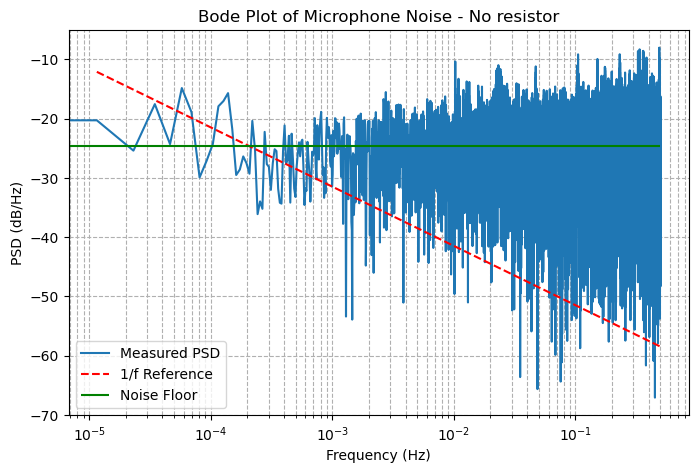

In [ ]:
# Remove DC offset
x = x - np.mean(x)

# Compute PSD
f, Pxx = welch(x, fs=fs, nperseg=86400)

# Plot measured PSD
plt.figure(figsize=(8,5))
plt.semilogx(f, 10 * np.log10(Pxx), label='Measured PSD')

# 1/f reference line
f_ref = np.linspace(f[1], f[-1], 1000)
freq_norm = 0.001
idx_norm = np.argmin(np.abs(f - freq_norm))
p_ref = Pxx[idx_norm]
ref_line = p_ref * (freq_norm / f_ref)
plt.semilogx(f_ref, 10 * np.log10(ref_line), 'r--', label='1/f Reference')

# Estimate and plot noise floor
hf_start = int(len(f) * 0.9)
noise_floor_level = np.median(Pxx[hf_start:])
plt.hlines(10 * np.log10(noise_floor_level), f[0], f[-1], colors='g', linestyles='-', label='Noise Floor')


# Plot formatting
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.title('Bode Plot of Microphone Noise - No resistor')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()
